# Тестовое задание

**Бизнес задача:**<br>
В сети интернет возникает много контента, который запрещен к показу на территории РФ.<br>
Этот контент может быть как тектовым, содержатся в изображениях, так и звуковым.<br>
Задача выявлять этот контент и блокировать.

**Техническая задача:**<br>
1. Задача классификации:<br> 
Есть изначально список категорий, которые запрещены к показу.
Нужно для вновь прибывших текстовых и графических данных относить либо к категории из списка выше, те "запрещенным категориям", при этом указать конкретную категория, либо к "разрешенным категориям".<br>
<br>
2. Задача кластаризации:<br>
Нужно кластеризовать имеющийся контент. При этом изначальный список категорий не дан. 
Выделить в контенте различные категории, содержащиеся в нем.

**Решение:**<br>
Для решения загрузим встроенный в Sklearn текстовый *dataset fetch_20newsgroups* .<br> 
«The 20 Newsgroups» — это коллекция примерно из 20000 новостных документов в основном писем, разделенная равномерно между 20 различными категориями.



**Содержание**:
1. Загрузка и предобработка данных <br>
2. Задача классификации: <br>
    2.1 Выбор метрики и обоснование ее<br>
    2.2 Подготовка Pipeline модели<br>
    2.3 Улучшение модели с помощью перебора параметров<br>
    2.4 Прогноз для отложенной выборке<br>
3. Задача кластаризации<br>
    3.1 Выбор метрики и обоснование ее<br>
    3.2 Подготовка данных<br>
    3.3 Запуск модели кластаризации<br>
4. Задача классификации изображения<br>
    4.1 Выбор метрики модели<br>
    4.2 Запуск модели<br>
5. Результаты работы<br>
6. Что можно сделать еще:<br>
7. Используемые материалы








In [167]:
#Отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')
import itertools

#Загружаем данные, встроенные в sklearn
from sklearn.datasets import fetch_20newsgroups

#Библиотеки машинного обучения
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#Библиотеки для классификации
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

#Библиотеки для кластаризации
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, MiniBatchKMeans, DBSCAN, MeanShift, Birch
from sklearn.mixture import GaussianMixture

# 1. Загрузка и предобработка данных

In [22]:
# Для удобства и быстроты расчетов выделим несколько категорий
categories = ['soc.religion.christian','comp.graphics', 'sci.med']

In [23]:
# Загружаем данные
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [24]:
# Посмотрим первый элемент в данных, те первое письмо.
print(twenty_train.data[0])

From: tbrent@ecn.purdue.edu (Timothy J Brent)
Subject: Am I going to Hell?
Organization: Purdue University Engineering Computer Network
Lines: 12

I have stated before that I do not consider myself an atheist, but 
definitely do not believe in the christian god.  The recent discussion
about atheists and hell, combined with a post to another group (to the
effect of 'you will all go to hell') has me interested in the consensus 
as to how a god might judge men.  As a catholic, I was told that a jew,
buddhist, etc. might go to heaven, but obviously some people do not
believe this.  Even more see atheists and pagans (I assume I would be 
lumped into this category) to be hellbound.  I know you believe only
god can judge, and I do not ask you to, just for your opinions.

Thanks,
-Tim



In [31]:
#Выведем наши категории, как они записались, а также метку для нашего документа.
print("Катогории: ", twenty_train.target_names)
print("Первые 10 документов: ", twenty_train.target[:10])
print('Категория нашего примера: ',twenty_train.target_names[2])



Катогории:  ['comp.graphics', 'sci.med', 'soc.religion.christian']
Первые 10 документов:  [2 0 0 0 0 0 2 0 0 1]
Категория нашего примера:  soc.religion.christian


Видим, что разделы:<br>
*'comp.graphics'*  соотвествует цифре 0<br>
*'sci.med'*  соотвествует цифре 1<br>
*'soc.religion.christian'*  соотвествует цифре 2<br>

Таким образом мы видим, что наш пример в тексте пренадлежит к разделу религии,<br>
не смотря на то, что письмо написано организатору в "Purdue University Engineering Computer Network"

# 2. Задача классификации:

### 2.1 Выбор метрики и обоснование ее

Для простоты решения задачи, а также интерпретации, выберем метрику accuracy.<br>
Но метрика accuracy не является самым правильным выбором в нашей задаче.<br>
Так гораздо важнее найти документ, который запрещен к показу, чем тот, который разрещен.<br>
Поэтому лучше ошибиться и назвать *"НЕзапрещенный"* документ *"Запрещенным"*, чем наоборот.<br>
Таким образом для продакшен лучше использовать recall или F-меру.<br>

### 2.2 Подготовка Pipeline модели 

Так как мы анализируем текстовые данные, то опишем Pipeline нашей модели.<br>
1) с помощью CountVectorizer подсчитаем количество употребление каждого слова <br>
2) с помощью TF-IDF для каждого слова подсчитаем относительную величину его употребления в документе и умножим на вес.<br> 
При этом частоупотребляемым словам дадим небольшой вес, а редко употребляемым большой.<br> 
Это объясняется тем, что предлоги и местоимения - это часто употребляемые слова и в себе не несут никакого смысла, а <br> редкоупотребляемые слова несут в себе смысл текста.<br>

In [32]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])

In [98]:
clfs = [MultinomialNB(), SGDClassifier(random_state=42)]
clfs_name = ['MultinomialNB','SGDClassifier']

In [104]:
#Перебираем параметры классификатора в поисках лучшего (на 3 фолдах)
np.random.seed(42)
for i, each_clf in enumerate(clfs):
    text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', each_clf)])
    text_clf = text_clf.fit(twenty_train.data, twenty_train.target)
    predicted = text_clf.predict(docs_test)
    print(clfs_name[i], 
          np.mean(cross_val_score(text_clf, twenty_train.data, twenty_train.target, scoring='accuracy', cv=3)))

MultinomialNB 0.9465269277118175
SGDClassifier 0.9752479814797378


**Вывод:** Получили, что **доля правильных ответов 97%** и,что SGDClassifier показал результат лучше.<br>
           Но не будем cпешить!

### 2.3 Улучшение модели с помощью перебора параметров 

Попробуем настроить каждую модель и перебрать параметры.<br>
При этом будем перебирать параметры не только моделей, но и обработки текста, те параметры CountVectorizer и TF-IDF

In [118]:
#Приступим к выбору модели
#Список классификаторов
clfs = [MultinomialNB(),
               SGDClassifier(random_state=42)]
clfs_name = ['MultinomialNB',
                  'SGDClassifier'] 

In [119]:
#Параметры классификаторов и CountVectorizer и TF-IDF
scores = []
fits = []
nb_params = {'clf__alpha': (0,1e-2, 1e-3, 0.01, 0.1, 0.25, 0.5, 1, 2),
            'clf__fit_prior':(True,False)}

sgd_params = {'clf__penalty': ('l1','l2'),
              'clf__n_iter': list(range(5, 35, 7))}

count_tfidf = {'vect__ngram_range': [(1, 1), (1, 2)],
               'vect__stop_words': ('english',None),
               'tfidf__use_idf': (True, False)}

# Добавляем к параметрам модели, параметры CountVectorizer и TF-IDF
nb_params.update(count_tfidf)
sgd_params.update(count_tfidf)

params = [nb_params, sgd_params]

In [120]:
%%time
#Перебираем параметры классификаторов в поисках лучшего (на 3 фолдах)
np.random.seed(42)
for i, each_clf in enumerate(clfs):
#    clf = each_clf
    clf_params = params[i]
    text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', each_clf)])    
    
    grid = GridSearchCV(text_clf, clf_params, 
                        cv=3,
                        scoring='accuracy',
                        n_jobs=-1)
    grid.fit(twenty_train.data, twenty_train.target)
    fits.append(grid.best_params_)
    clf_best_score = grid.best_score_
    scores.append(clf_best_score)
    print(clfs_name[i], clf_best_score, "\n", grid.best_params_, "\n")

MultinomialNB 0.983680360157569 
 {'clf__alpha': 0.001, 'clf__fit_prior': False, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'} 

SGDClassifier 0.9819921215531795 
 {'clf__n_iter': 26, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'} 

CPU times: user 15.4 s, sys: 2.53 s, total: 18 s
Wall time: 12min 44s


**Вывод:** Перебрав параметры модели получили, что при определенных настройках MultinomialNB работает лучше.<br>
           **Доля правильно** классифицированных примеров составила **98%**

### 2.4 Прогноз для отложенной выборке

In [121]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', MultinomialNB(alpha=0.001, fit_prior = False))])    


In [122]:
# Загружаем тестовые данные
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# Обучаем CountVectorizer и TF-IDF 
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

# Делаем прогноз и смотрим оценку на тестовой выборке
predicted = text_clf.predict(twenty_test.data)
accuracy_score(twenty_test.target, predicted, normalize=True) 

0.9602704987320372

**Вывод** На отложенной выборке, результаты модели чуть хуже, поэтому нужно посмотреть и убедиться не было ли у нас переобучения.

# 3. Задача кластаризации

### 3.1 Выбор метрики и обоснование ее


Используем аналогичную меру, как и в прошлой части.<br>
Так как у нас есть правильные ответы, мы сможем сравнить на сколько наша кластаризация будет хорошей.<br>
Но так как кластаризация нам поделит наши данные на кластеры и эти кластеры, не обязательно должны совпадать с нашими изначальными метками, напишиму функцию валидации, которая будет проверять все комбинации соотвестивя полученной метки и метки в ответах.

In [177]:
def validate_with_mappings(preds, target):
    permutations = itertools.permutations([0,1,2])
    scores=[]
    for a,b,c in permutations:
        mapping = {2: a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
        scores.append(sum(mapped_preds==target)/len(target))
        
    return np.max(scores)


### 3.2 Подготовка данных

Используем Pipline из предыдущего раздела.<br>
Единственно заменим функции CountVectorizer() и TfidfTransformer() одной функцией TfidfVectorizer(), тк эта функция объединяет в себе две других.

In [ ]:
categories = ['soc.religion.christian','comp.graphics', 'sci.med']

In [214]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [228]:
vectorizer = TfidfVectorizer(max_df=500, min_df=10, stop_words='english')
matrix = vectorizer.fit_transform(twenty_train.data)

### 3.3 Запуск модели кластаризации

Для тестирование запустим две модели кластаризации: "агломеративную кластеризацию" и "KMeans"

In [229]:
# Задаем методы класторизации
cls = [KMeans(n_clusters=3,random_state=42),  AgglomerativeClustering(n_clusters=3)]
cls_name = ['KMeans','AgglomerativeClustering']

In [230]:
%%time
#Перебираем методы класторизации
np.random.seed(42)
for i, each_cls in enumerate(cls):
    
    model = each_cls
    preds = model.fit_predict(matrix.toarray())

    print(cls_name[i], validate_with_mappings(preds, simple_dataset.target))

KMeans 0.980435997764114
AgglomerativeClustering 0.8982671883733929
CPU times: user 35.7 s, sys: 2.03 s, total: 37.7 s
Wall time: 33.8 s


**Вывод** Модель КMeans показала себя лучше. <br>
          Точность кластаризации составляет 98%

# 4. Задача классификации изображения

Была создана выборка с помошью Яндекс.Картинок по запросам "экстримсткий митинг" и "санкционированные шествия". <br>
Всего в каждой выборке 100 фотографий, 70 в обучающей выборке, 30 в тестовой.

**PS** Понятно, что для нейронной сети требуется гораздо больше фотографий для обучения.<br>
Тогада она показывает гораздо лучше результаты. Но продемонстрируем работу алгоритма на существующих данных.

Для решения использовалась нейронная сеть ResNet18

За основу был использован код из статьи про Transfer_learning с небольшими улучшениями.<br>
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Для более быстрого запуска, можно запустить код в colab.research.google.com , тк там можно использовать GPU<br> 
Посмотреть код, а также используемые данные можно по ссылке: https://goo.gl/C6Ze4B  

### 4.1 Выбор метрики модели

В качестве метрики выберем аналогичную метрику, как и в других разделах accuracy доля правильных ответов.

### 4.2 Запуск модели

In [241]:
# Устанавливаем Pytorch
#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision pillow

torch-0.3.0.post4-{platform}-linux_x86_64.whl is not a valid wheel filename.


In [19]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


import random
import numpy as np
import pandas as pd

#Графика
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


plt.ion()   

In [20]:
# Аргументация и нормализация тренеровочных данных
# Только нормализация для валидационной выборки
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], drop_last=False, batch_size=16,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

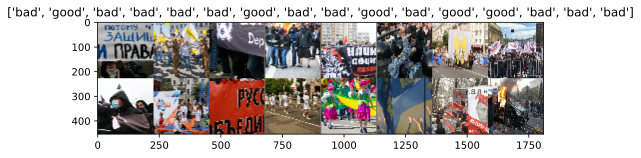

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
# Моя функция по рисованию графиков LOSS и ACC на train/test

def plot_learning_curve(epoch, epoch_loss_train_plt, epoch_loss_val_plt, epoch_acc_train_plt, epoch_acc_val_plt):
  df1 = pd.DataFrame({'epoch':epoch_plt + epoch_plt ,'loss':list(epoch_loss_train_plt) + list(epoch_loss_val_plt), 'sample': ('train '*len(epoch_plt) + 'val '*len(epoch_plt)).split() })
  df2 = pd.DataFrame({'epoch':epoch_plt + epoch_plt ,'acc':list(epoch_acc_train_plt) + list(epoch_acc_val_plt), 'sample': ('train '*len(epoch_plt) + 'val '*len(epoch_plt)).split() })

  fig, axes = plt.subplots(1, 2, figsize=(25,6))
  sns.pointplot(x='epoch',y='loss' ,data=df1, hue='sample', ax=axes[0]); 
  sns.pointplot(x='epoch',y='acc' ,data=df2, hue='sample', ax=axes[1])  

  fig.show()



In [5]:
epoch_loss_train_plt=[]
epoch_acc_train_plt=[]

epoch_loss_val_plt=[]
epoch_acc_val_plt=[]

epoch_plt=[]

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        #Для графика
        epoch_plt.append(epoch) 
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            #Для графиков
            
            if phase == 'train':
              epoch_loss_train_plt.append(epoch_loss)
              epoch_acc_train_plt.append(epoch_acc)
            else:
              epoch_loss_val_plt.append(epoch_loss)
              epoch_acc_val_plt.append(epoch_acc)
              
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    #Графики score и acc на train и val
    plot_learning_curve(epoch_plt, epoch_loss_train_plt, epoch_loss_val_plt,epoch_acc_train_plt, epoch_acc_val_plt)

    
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [7]:
%%time

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.Adam(model.parameters(), lr = 0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


CPU times: user 2 s, sys: 232 ms, total: 2.24 s
Wall time: 2.26 s


Epoch 0/2
----------
train Loss: 0.6913 Acc: 0.5652
val Loss: 0.4264 Acc: 0.8966

Epoch 1/2
----------
train Loss: 0.4780 Acc: 0.7609
val Loss: 0.2358 Acc: 0.9310

Epoch 2/2
----------
train Loss: 0.3417 Acc: 0.8406
val Loss: 0.1280 Acc: 0.9828

Training complete in 12m 34s
Best val Acc: 0.982759
CPU times: user 24min 1s, sys: 16min 13s, total: 40min 15s
Wall time: 12min 35s


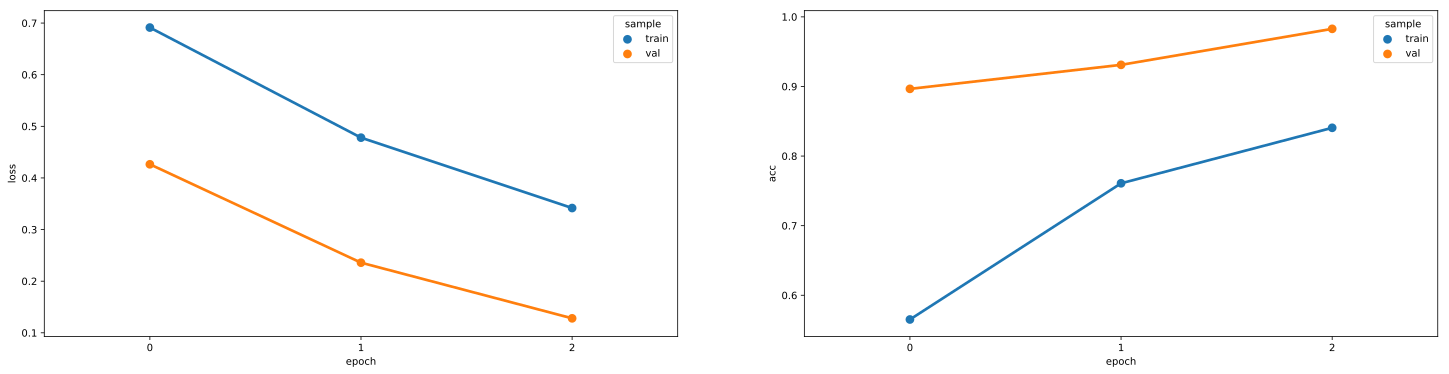

In [8]:
%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=3)

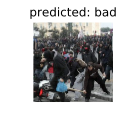

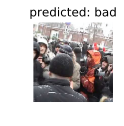

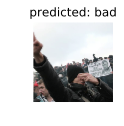

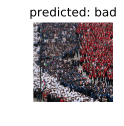

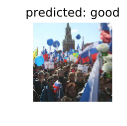

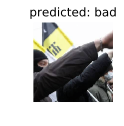

In [12]:
visualize_model(model_ft, num_images=6)

**Вывод:** Была достигнута точность 98%, единственно не стоит так радоваться в нашей выборке было всего 100 фотографий<br> 
и вероятность угадывания правильных ответов очень большая, поэтому действительная точность около 70%.<br>
Что тоже неплохо.

# Результаты работы

**Бизнес задача**<br>
Теперь с помощью разработанной модели, можно выявлять недоброжелательный контент и блокировать

**Техническая задача**<br>
Были решены задача классификации и кластаризации.<br>
Таким образом с помощью метода кластаризации можно создать нежелательные категории, далее<br>
применять методы классификации для нового контента.

# Что можно сделать еще

**Feature Engineering**<br>
Чтобы улучшить текстовые данные,а также изображения, можно использовать еще следующие вещи:<br>
1. Леммезация, нормализация. Это поможет моделе более качественно воспринимать слова.<br>
2. Ручной отбор стоп-слов, те слов, которые не должны участвовать в моделе.<br>
3. Постороение новый признаков, например, можно сделать:<br>
    -отдельным признаком,есть слово в тексте из запрещенных категорий.<br>
    -построить отдельную большую модели TF-IDF со всеми запрещенными тексати, а также отдельно модели TF-IDF для  
     каждой запрещенной <br>
4. Для картинок увеличить количество данных и попробовать разные агломерации.<br>


**Modeling**<br>
1. Использовать многолайбел классификацию. Так как понятно, что один и тот же текст может относиться к разным тематикам.<br>
2. Использовать метод блендинга моделей. Если просто усредний показатели всех моделей, то метрику можно улучшить.<br>
3. Для кластаризации запустить GreadSearchCV для выявления наилучших параматров.<br>





# 7. Используемые материалы


1) https://habr.com "Работа с текстовыми данными в scikit-learn "<br>
2) курс "Практический анализ данных" на coursera, раздел Кластаризация<br>
3) документация PyTorch по "Transfer learning pytorch" <br> 
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 